<a href="https://colab.research.google.com/github/nafizahamed8/Artificial-Intelligence-repo/blob/main/Transformer_Based_Approach_UCI_HAR_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
train_data_path = "/content/drive/MyDrive/UCI HAR Dataset/train/X_train.txt"
train_labels_path = "/content/drive/MyDrive/UCI HAR Dataset/train/y_train.txt"
test_data_path = "/content/drive/MyDrive/UCI HAR Dataset/test/X_test.txt"
test_labels_path = "/content/drive/MyDrive/UCI HAR Dataset/test/y_test.txt"

In [ ]:
X_train = pd.read_csv(train_data_path, header=None, delim_whitespace=True)
y_train = pd.read_csv(train_labels_path, header=None)
X_test = pd.read_csv(test_data_path, header=None, delim_whitespace=True)
y_test = pd.read_csv(test_labels_path, header=None)

<ipython-input-4-f2305daab260>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(train_data_path, header=None, delim_whitespace=True)
<ipython-input-4-f2305daab260>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(test_data_path, header=None, delim_whitespace=True)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.values.ravel())
y_test = label_encoder.transform(y_test.values.ravel())

In [ ]:
# Concatenate the datasets
X_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train, y_test))

In [ ]:
# --- Data Augmentation Functions ---
def jitter(X, sigma=0.05):
    """Adds random noise to the input data."""
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise

def scaling(X, sigma=0.1):
    """Scales the input data by a random factor."""
    scaling_factor = np.random.normal(loc=1.0, scale=sigma, size=(X.shape[0], 1))
    return X * scaling_factor

def permutation(X, max_segments=5, seg_mode="equal"):
    """Randomly permutes segments within the time series."""
    orig_steps = np.arange(X.shape[2])  # Assuming your data is 3D: (samples, channels, time steps)
    num_segs = np.random.randint(1, max_segments, size=(X.shape[0]))
    ret = np.zeros_like(X)
    for i, pat in enumerate(X):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(X.shape[2] - 2, num_segs[i] - 1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[0, warp]  # Accessing the channels dimension with index 0
        else:
            ret[i] = pat
    return ret

In [ ]:
X_augmented = jitter(X_all)
X_augmented = scaling(jitter(X_all))

In [ ]:
# Add augmented data to your dataset
X_all = np.concatenate((X_all, X_augmented))
y_all = np.concatenate((y_all, y_all))


In [ ]:
X_all = X_all.reshape(-1, 1, X_all.shape[1])

In [ ]:
len(X_all)

20598

In [ ]:
# Convert to PyTorch tensors
X_all_tensor = torch.tensor(X_all, dtype=torch.float32)
y_all_tensor = torch.tensor(y_all, dtype=torch.long)

In [ ]:
# Split into train, validation, and test sets
X_train_split, X_temp, y_train_split, y_temp = train_test_split(
    X_all_tensor, y_all_tensor, test_size=0.3, random_state=42
)
# %%
X_val_split, X_test_split, y_val_split, y_test_split = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [ ]:
# Create DataLoaders for train, validation, and test sets
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset = TensorDataset(X_val_split, y_val_split)
test_dataset = TensorDataset(X_test_split, y_test_split)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
len(train_dataset)

14418

In [ ]:
len(test_dataset)

3090

In [ ]:
len(val_dataset)

3090

In [ ]:
import torch.nn.functional as F
# --- Transformer Model Definition ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i / self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = self.scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out

    def scaled_dot_product(self, q, k, v, mask=None):
        d_k = q.size()[-1]
        scaled = torch.matmul(q, k.transpose(-1, -2)) / torch.sqrt(torch.tensor(d_k))
        if mask is not None:
            scaled += mask
        attention = F.softmax(scaled, dim=-1)
        values = torch.matmul(attention, v)
        return values, attention

class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(ffn_hidden, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, mask=None):
        residual = x
        x = self.attention(x, mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual)
        residual = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual)
        return x

In [ ]:
class TransformerForUCIHAR(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, num_classes, num_features):
        super().__init__()
        # Sensor embedding layer
        self.sensor_embedding = nn.Linear(num_features, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_sequence_length)

        # Transformer encoder
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)
        ])

        # Classification head
        self.classification_head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # Add sensor embedding and positional encoding
        x = self.sensor_embedding(x) + self.positional_encoding().to(x.device)

        # Pass through the encoder layers
        for layer in self.encoder_layers:
            x = layer(x)

        # Global average pooling
        x = x.mean(dim=1)

        # Predict the activity label
        x = self.classification_head(x)
        return x

In [ ]:
d_model = 64
ffn_hidden = 128
num_heads = 4
drop_prob = 0.1
num_layers = 2
max_sequence_length = 1  # Sequence length is 1 for UCI HAR Dataset
num_classes = 6  # Number of activity classes in UCI HAR Dataset
num_features = 561  # Number of features in UCI HAR Dataset

In [ ]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerForUCIHAR(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, num_classes, num_features).to(device)

In [ ]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# --- Training Loop ---
train_losses = []
val_losses = []
epochs = 20

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
train_accuracies = []
val_accuracies = []
correct_train = 0
total_train = 0
correct_val = 0
total_val = 0

In [ ]:
best_val_loss = float('inf')
patience = 5
trigger_times = 0


In [ ]:
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        _,predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
    train_losses.append(epoch_train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_val_loss += loss.item()
            _,predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)



    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
         best_val_loss = val_losses[-1]
         trigger_times = 0
    else:
         trigger_times +=1
    if trigger_times > patience:
         print("Early stopping triggered")
         break

Epoch 1/20, Train Loss: 0.2485, Validation Loss: 0.0888
Epoch 2/20, Train Loss: 0.0834, Validation Loss: 0.1010
Epoch 3/20, Train Loss: 0.0659, Validation Loss: 0.0627
Epoch 4/20, Train Loss: 0.0624, Validation Loss: 0.0534
Epoch 5/20, Train Loss: 0.0518, Validation Loss: 0.0436
Epoch 6/20, Train Loss: 0.0466, Validation Loss: 0.0511
Epoch 7/20, Train Loss: 0.0453, Validation Loss: 0.0598
Epoch 8/20, Train Loss: 0.0449, Validation Loss: 0.0398
Epoch 9/20, Train Loss: 0.0360, Validation Loss: 0.0510
Epoch 10/20, Train Loss: 0.0338, Validation Loss: 0.0348
Epoch 11/20, Train Loss: 0.0357, Validation Loss: 0.0371
Epoch 12/20, Train Loss: 0.0311, Validation Loss: 0.0346
Epoch 13/20, Train Loss: 0.0223, Validation Loss: 0.0277
Epoch 14/20, Train Loss: 0.0213, Validation Loss: 0.0377
Epoch 15/20, Train Loss: 0.0259, Validation Loss: 0.0729
Epoch 16/20, Train Loss: 0.0229, Validation Loss: 0.0484
Epoch 17/20, Train Loss: 0.0175, Validation Loss: 0.0271
Epoch 18/20, Train Loss: 0.0157, Validat

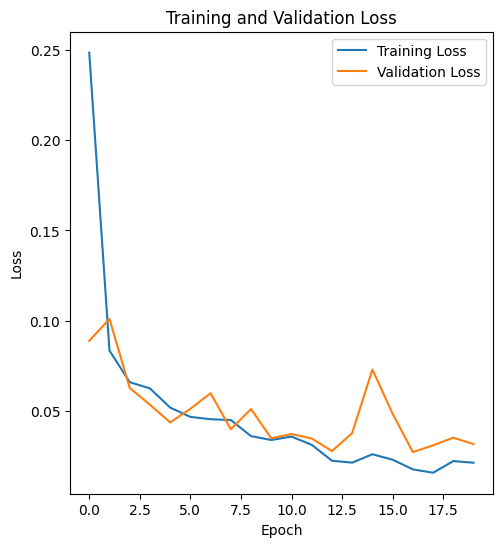

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

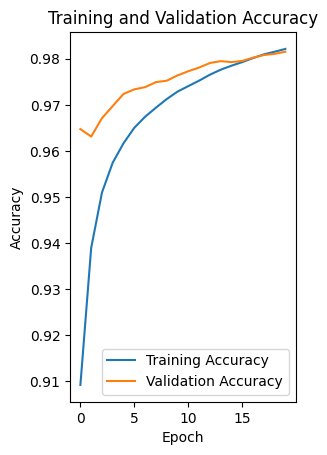

In [ ]:
# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# --- Model Evaluation on Test Set ---
model.eval()
with torch.no_grad():
    # Use X_test_split instead of X_test_tensor
    X_test_tensor = X_test_split.to(device)  # Move test data to device
    test_outputs = model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)
    # Move y_test_split to device
    test_loss = criterion(test_outputs, y_test_split.to(device))
    test_accuracy = accuracy_score(y_test_split.cpu().numpy(), test_preds.cpu().numpy())
    print(f"Test Loss: {test_loss.item()}, Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.024553589522838593, Test Accuracy: 99.22%


In [ ]:
y_test_tensor = y_test_split.to(device)

cm = confusion_matrix(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy())

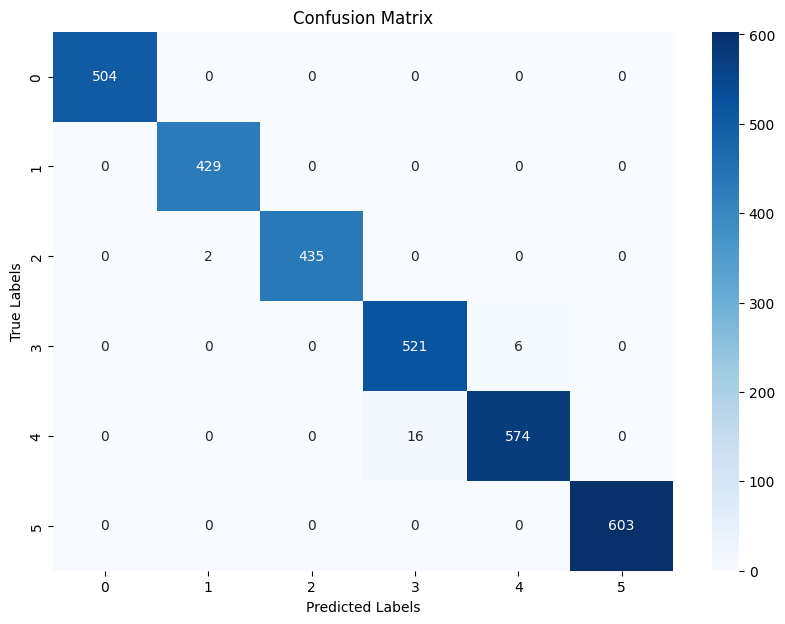

Accuracy: 0.9922330097087378


In [ ]:
y_test_tensor = y_test_split.to(device)

cm = confusion_matrix(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy())
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print(f"Accuracy: {accuracy_score(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy())}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


In [ ]:
# Calculate metrics
precision = precision_score(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')
recall = recall_score(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')
f1 = f1_score(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print the classification report for class-wise metrics and averages
print(classification_report(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy()))

Precision: 0.9923
Recall: 0.9922
F1-score: 0.9922
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       1.00      1.00      1.00       429
           2       1.00      1.00      1.00       437
           3       0.97      0.99      0.98       527
           4       0.99      0.97      0.98       590
           5       1.00      1.00      1.00       603

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



In [ ]:
print("\n--- Summary of Accuracies ---")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


--- Summary of Accuracies ---
Final Training Accuracy: 0.9821
Final Validation Accuracy: 0.9815
Test Accuracy: 0.9922


In [ ]:
if test_accuracy < val_accuracies[-1] - 0.05: # added a condition here to see if test set has a much lower accuracy.
       print("\nTest accuracy is significantly lower than validation accuracy. This suggests possible overfitting.")
elif test_accuracy < train_accuracies[-1] - 0.05: # added a condition here to see if test set has a much lower accuracy than train set.
       print("\nTest accuracy is significantly lower than training accuracy. This suggests possible overfitting.")
elif test_accuracy > train_accuracies[-1] + 0.05 or test_accuracy > val_accuracies[-1] + 0.05: # added a condition here to see if the test set accuracy is much better than training and validation.
      print("\nTest accuracy is much better than validation and training accuracy. This may mean something is wrong with the splitting of your data.")
else:
      print("\nTest accuracy is close to training and validation accuracy. This suggests good generalization.")


Test accuracy is close to training and validation accuracy. This suggests good generalization.
